# Intro

In this notebook we'll develop a distributed lag model to predict the Remaining Useful Life (RUL) of FD001. You can find a full explanation of the code in my accompanying blog post [here](https://towardsdatascience.com/time-series-analysis-for-predictive-maintenance-of-turbofan-engines-1b3864991da4?source=friends_link&sk=a62dbeb8230f6b29123b692ac08dad59)  

<disclaimer: I aim to showcase the effect of different methods and choices made during model development. These effects are often shown using the test set, something which is considered (very) bad practice but helps for educational purposes.>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

## Load data and compute RUL

In [2]:
# define filepath to read data
dir_path = './CMAPSSData/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

In [3]:
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [5]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, Variance:{}'.format(label, rmse, variance))

In [6]:
# drop unwanted columns based on Exploratory Data Analysis conducted earlier
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = setting_names+drop_sensors

X_train = train.drop(drop_labels, axis=1)
# y_train = X_train.pop('RUL')  # pop RUL after dropping NaNs introduced by creating lagged variables

X_test_interim = test.drop(drop_labels, axis=1)

## Adding lagged variables

In [7]:
# lagged variables toy example
np.random.seed(42)
toy_df = pd.DataFrame({'value': np.random.rand(5)})
toy_df['value_lag_1'] = toy_df['value'].shift(1)
toy_df['value_lag_2'] = toy_df['value'].shift(2)
display(toy_df)

,value,value_lag_1,value_lag_2
0,0.374540,NaN,NaN
1,0.950714,0.374540,NaN
2,0.731994,0.950714,0.374540
3,0.598658,0.731994,0.950714
4,0.156019,0.598658,0.731994


Notice how row 2 contains the data of t, t-1 and t-2. By adding these lagged variables you can thus represent data of multiple timesteps in a single row.  Which can then be used by our model.  
Let's try to implement it

In [8]:
# create lagged variables
remaining_sensors = X_train.columns.difference(index_names+['RUL'])
lag1 = [col + '_lag_1' for col in remaining_sensors]

X_train[lag1] = X_train.groupby('unit_nr')[remaining_sensors].shift(1)
X_train.dropna(inplace=True)

X_test_interim[lag1] = X_test_interim.groupby('unit_nr')[remaining_sensors].shift(1)
X_test_interim.dropna(inplace=True)

In [9]:
X_train.head()

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,...,s_15_lag_1,s_17_lag_1,s_2_lag_1,s_20_lag_1,s_21_lag_1,s_3_lag_1,s_4_lag_1,s_7_lag_1,s_8_lag_1,s_9_lag_1
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,...,8.4195,392.0,641.82,39.06,23.4190,1589.70,1400.60,554.36,2388.06,9046.19
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,...,8.4318,392.0,642.15,39.00,23.4236,1591.82,1403.14,553.75,2388.04,9044.07
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,...,8.4178,390.0,642.35,38.95,23.3442,1587.99,1404.20,554.26,2388.08,9052.94
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,...,8.3682,392.0,642.35,38.88,23.3739,1582.79,1401.87,554.45,2388.11,9049.48
5,1,6,642.10,1584.47,1398.37,554.67,2388.02,9049.68,47.16,521.68,...,8.4294,393.0,642.37,38.90,23.4044,1582.85,1406.22,554.00,2388.06,9055.15


In [10]:
# target variable
y_train = X_train.pop('RUL')

# prep test data, since the true RUL values for the test set are only provided for the last time cycle
# of each enginge, the test set is subsetted to represent the same
X_test = X_test_interim.groupby('unit_nr').last().reset_index()

In [11]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:39.367692351135005, Variance:0.6709929595362338
test set RMSE:31.423109839706022, Variance:0.42820706786532714


It works! The evaluation scores are slightly better compared to the linear regression of of our baseline model with an RMSE of 31.95.  
Now lets create a function for adding multiple laggs

In [12]:
def add_lagged_variables(df_input, nr_of_lags, columns):
    df = df_input.copy()
    for i in range(nr_of_lags):
        lagged_columns = [col + '_lag_{}'.format(i+1) for col in columns]
        df[lagged_columns] = df.groupby('unit_nr')[columns].shift(i+1)
    df.dropna(inplace=True)
    return df

In [13]:
def add_specific_lags(df_input, list_of_lags, columns):
    df = df_input.copy()
    for i in list_of_lags:
        lagged_columns = [col + '_lag_{}'.format(i) for col in columns]
        df[lagged_columns] = df.groupby('unit_nr')[columns].shift(i)
    df.dropna(inplace=True)
    return df

# Stationarity
Stationarity implies the statistical properties of the time series, such as mean and variance do not change over time, in addition the covariance (spread of the time series) should not be dependent on time (see figure below).  
It is important that these statistical properties stay constant because a lot of statistical models rely on these properties for their predictions. Hence, if the mean, variance or covariance changes with time the model would not be able to accurately predict the next value [1]

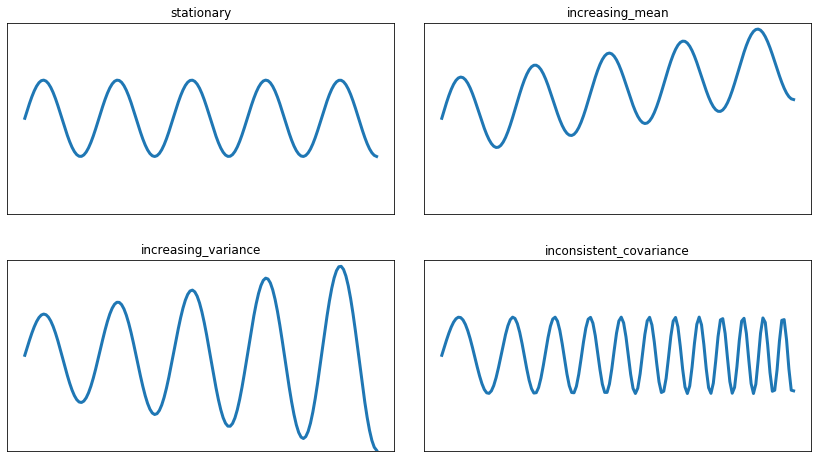

In [14]:
# stationarity graphs
t = np.arange(0,150)
factor = 0.2
stationary = np.sin(factor*t)
increasing_mean = np.sin(factor*t) + t/100
increasing_variance = np.sin(factor*t) * (1 + t/100)
inconsistent_covariance = np.sin((factor + t/500) * t)

plotlist = [stationary, increasing_mean, increasing_variance, inconsistent_covariance]
plotnames = ['stationary', 'increasing_mean', 'increasing_variance', 'inconsistent_covariance']  # not very elegant but gets the job done

plt.subplots(2, 2, figsize=(12,7))  # initiate subplot figure
ylim = 2.5

for i in range(len(plotlist)):

    plt.subplot(2, 2, i+1)  # define which subplot to fill, range starts at 0 so increment with 1
    plt.plot(t, plotlist[i], linewidth=3)
    plt.ylim(-ylim, ylim)
    plt.tick_params(which='both', bottom=False, labelbottom=False, left=False, labelleft=False)  # remove axis ticks and labels
    plt.title(str(plotnames[i]))

plt.tight_layout(pad=3)  # specify layout and whitespace padding between graphs
plt.show()
# plt.close()

In [15]:
# test stationarity using adfuller test
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, n_obs, critical_values, icbest = adfuller(train[ 's_7'], maxlag=1)
print('all units, single column test results')
print('adf: {} \npvalue: {}'.format(adf, pvalue))
print('Significant: {}'.format(pvalue < 0.05))
print('NOTE: Testing one column has values of 100 engines, all engines together are stationary, but single engines are not!\n')

test_series = train.loc[train['unit_nr']==1, 's_7']
adf, pvalue, usedlag, n_obs, critical_values, icbest = adfuller(test_series, maxlag=1)
print('single unit, single column test results')
print('adf: {} \npvalue: {}'.format(adf, pvalue))
print('Significant: {}\n'.format(pvalue < 0.05))

test_series = test_series.diff(1).dropna()
adf, pvalue, usedlag, n_obs, critical_values, icbest = adfuller(test_series, maxlag=1)
print('single unit, single column test results after differencing')
print('adf: {} \npvalue: {}'.format(adf, pvalue))
print('Significant: {}\n'.format(pvalue < 0.05))

all units, single column test results
adf: -32.413164189329294 
pvalue: 0.0
Significant: True
NOTE: Testing one column has values of 100 engines, all engines together are stationary, but single engines are not!

single unit, single column test results
adf: -2.276666927948019 
pvalue: 0.17960380425358546
Significant: False

single unit, single column test results after differencing
adf: -14.824168539718967 
pvalue: 1.9431018596392618e-27
Significant: True



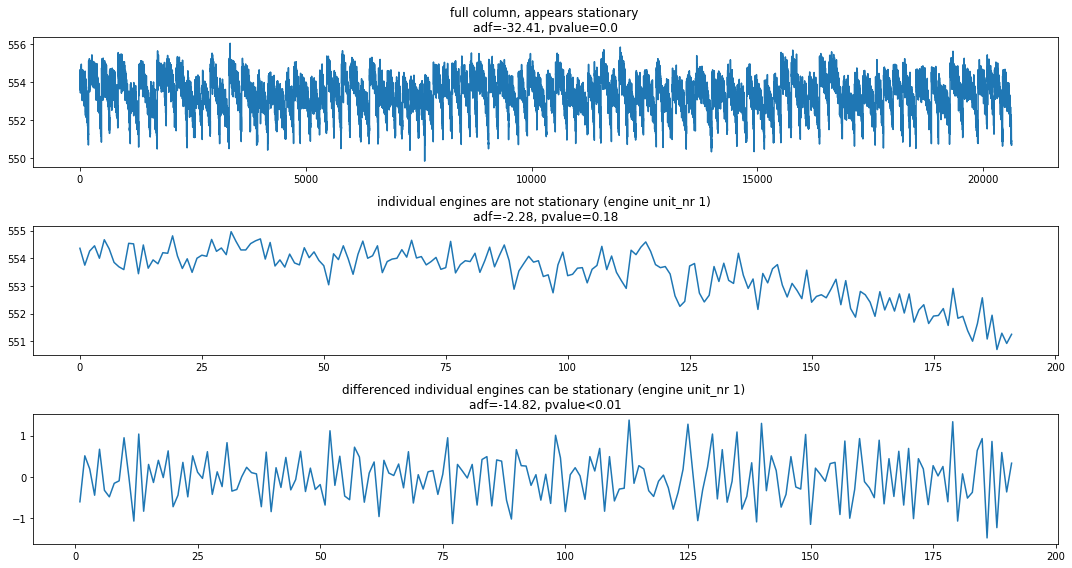

In [16]:
# full column vs single unit
plt.subplots(3,1, figsize=(15,8))

plt.subplot(3,1,1)
plt.plot(train[ 's_7'])
plt.title('full column, appears stationary \n\
adf=-32.41, pvalue=0.0')


plt.subplot(3,1,2)
plt.plot(train.loc[train['unit_nr']==1, 's_7'])
plt.title('individual engines are not stationary (engine unit_nr 1) \n\
adf=-2.28, pvalue=0.18')


plt.subplot(3,1,3)
plt.plot(train.loc[train['unit_nr']==1, 's_7'].diff(1).dropna())
plt.title('differenced individual engines can be stationary (engine unit_nr 1) \n\
adf=-14.82, pvalue<0.01')


plt.tight_layout()
plt.show()
# plt.close()

In [17]:
# test code to find the maximum times a time series needs to be differenced
unit = train.loc[train['unit_nr']==1].drop(drop_labels + ['unit_nr', 'time_cycles', 'RUL'], axis=1) # subset to unit nr 1 and sensors of interest.
for col in unit.columns:
    maxdiff = 0
    do = True
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(unit[col], maxlag=1)
    if pvalue < 0.05:
        do = False
    
    while do:
        maxdiff += 1
        adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(unit[col].diff(maxdiff).dropna(), maxlag=1)
        if pvalue < 0.05:  # if significant, stop differencing and testing for stationarity
            do = False
 
    print("{}: pvalue = {}, maxdiff = {}".format(col, pvalue, maxdiff))

s_2: pvalue = 0.0024595865644561916, maxdiff = 0
s_3: pvalue = 1.0520451518285957e-05, maxdiff = 0
s_4: pvalue = 4.60900610486878e-30, maxdiff = 1
s_7: pvalue = 1.9431018596392618e-27, maxdiff = 1
s_8: pvalue = 3.532206691038888e-30, maxdiff = 1
s_9: pvalue = 1.5681108573550618e-09, maxdiff = 0
s_11: pvalue = 8.864663797422956e-30, maxdiff = 1
s_12: pvalue = 3.5925713229506605e-29, maxdiff = 1
s_13: pvalue = 2.4063159325208005e-29, maxdiff = 1
s_14: pvalue = 0.0, maxdiff = 1
s_15: pvalue = 0.01424632892460841, maxdiff = 0
s_17: pvalue = 0.0016961883459593356, maxdiff = 0
s_20: pvalue = 0.0022189808492880272, maxdiff = 0
s_21: pvalue = 0.035645930791065164, maxdiff = 0


In [18]:
# wrap the code to find the max difference in a function and create a function to make the time-series stationary
def find_max_diff(series):
    maxdiff = 0
    do = True
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series, maxlag=1)
    if pvalue < 0.05:
        do = False
    
    while do:
        maxdiff += 1
        adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series.diff(maxdiff).dropna(), maxlag=1)
        if pvalue < 0.05:  # if significant, stop differencing and testing for stationarity
            do = False
    return maxdiff


def make_stationary(df_input, columns):
    df = df_input.copy()
    for unit_nr in range(1, df['unit_nr'].max()+1):
        for col in columns:
            maxdiff = find_max_diff(df.loc[df['unit_nr']==unit_nr, col])
            if maxdiff > 0:
                df.loc[df['unit_nr']==unit_nr, col] = df.loc[df['unit_nr']==unit_nr, col].diff(maxdiff)
    df.dropna(inplace=True)
    return df

### Apply what we have untill now

In [19]:
# make all remaining sensors stationary per unit_nr
intermediate_df = train.drop(drop_labels, axis=1)
intermediate_df = make_stationary(intermediate_df, remaining_sensors)

In [20]:
intermediate_df.head()  # stationary data!

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
1,1,2,642.15,1591.82,2.54,-0.61,-0.02,9044.07,0.02,0.62,0.05,-7.13,8.4318,392.0,39.00,23.4236,190
2,1,3,642.35,1587.99,1.06,0.51,0.04,9052.94,-0.22,0.14,-0.04,1.74,8.4178,390.0,38.95,23.3442,189
3,1,4,642.35,1582.79,-2.33,0.19,0.03,9049.48,-0.14,0.44,0.05,0.60,8.3682,392.0,38.88,23.3739,188
4,1,5,642.37,1582.85,4.35,-0.45,-0.05,9055.15,0.15,-0.67,-0.04,-0.03,8.4294,393.0,38.90,23.4044,187
5,1,6,642.10,1584.47,-7.85,0.67,-0.04,9049.68,-0.12,-0.51,-0.01,-0.95,8.4108,391.0,38.98,23.3669,186


In [21]:
# create and fit model
lm = LinearRegression()
lm.fit(intermediate_df[remaining_sensors], intermediate_df['RUL'])

# predict and evaluate
y_hat_train = lm.predict(intermediate_df[remaining_sensors])
evaluate(intermediate_df['RUL'], y_hat_train, 'train')

train set RMSE:51.63375613791181, Variance:0.4340864011385228


Training RMSE has become quite a bit worse as a result of making the data stationary. This can be explained by the data no longer having a trend, making it difficult to fit a regression line. Scores will improve again when adding lagged variables, as this will inform the model of the change of the sensor values over time

## AIC: searching for the correct number of lags

In [22]:
# add lags and evaluate models to find optimal lag length
import statsmodels.api as sm

metrics = pd.DataFrame(columns=['rmse', 'AIC', 'BIC'])
nr_of_lags = 30
for i in range(0, nr_of_lags+1):
    X_train = add_lagged_variables(intermediate_df, i, remaining_sensors)
    X_train = X_train.drop(index_names, axis=1)
    y_train = X_train.pop('RUL')
    
    model = sm.OLS(y_train, sm.add_constant(X_train.values))
    result = model.fit()

    metrics = metrics.append(pd.DataFrame(data=[[np.sqrt(result.mse_resid), round(result.aic,2), round(result.bic,2)]],
                               columns=['rmse', 'AIC', 'BIC']),
                               ignore_index = True)

display(metrics)

,rmse,AIC,BIC
0,51.652627,220271.65,220390.59
1,46.060503,214530.30,214760.12
2,43.058562,210753.82,211094.38
3,41.151503,207898.35,208349.51
4,39.833453,205574.27,206135.89
5,38.813294,203528.00,204199.94
6,37.986450,201667.95,202450.06
7,37.304649,199952.23,200844.37
8,36.723366,198338.72,199340.76
9,36.198014,196782.37,197894.15


Based on the table of the metrics it does not become clear how many lags to add as the metrics seem to keep improving.  
Let's try plotting a metric for any visual ques

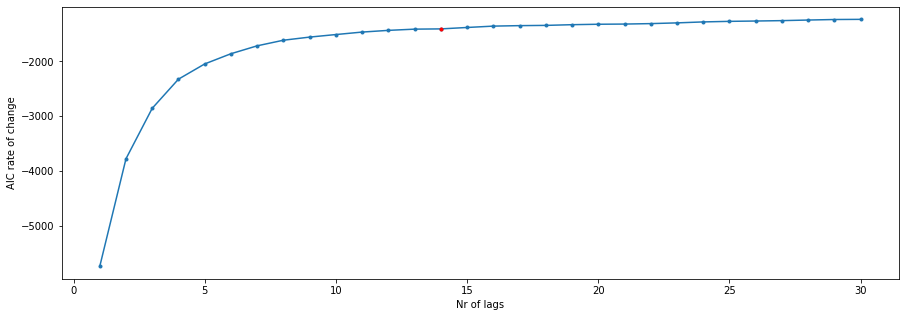

In [23]:
plt.figure(figsize=(15,5))
plt.plot(metrics['AIC'].diff(), marker='.')  # plot the difference to see where it flattens out
plt.plot(14, metrics['AIC'].diff()[14], '.r')
plt.xlabel("Nr of lags")
plt.ylabel("AIC rate of change")
plt.show()
plt.close()

Based on the graph I'd say improvement stagnates at 13-14 lags.  
One problem with adding multiple lags of the same variable is multicolinearity, let's check that next.

In [24]:
result.summary()  # Check warnings and condition number at the bottom of output

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     136.9
Date:                Sun, 30 Aug 2020   Prob (F-statistic):               0.00
Time:                        10:35:41   Log-Likelihood:                -83949.
No. Observations:               17533   AIC:                         1.688e+05
Df Residuals:                   17098   BIC:                         1.721e+05
Df Model:                         434                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.908e+04    165.898    114.981      0.000    1.88e+04    1.94e+04
x1            -0.5162      0.722     -0.715      0.474      -1.931       0.899
x2            -0.3837      0.055     -6.974      0.000      -0.492      -0.276
x3            -0.2225      0.047     -4.728      0.000      -0.315      -0.130
x4             1.2576      0.471      2.671      0.008       0.335       2.180
x5            14.4389      6.395      2.258      0.024       1.904      26.974
x6            -0.0607      0.046     -1.325      0.185      -0.150       0.029
x7            -7.1442      1.865     -3.830      0.000     -10.800      -3.488
x8             1.5610      0.624      2.501      0.012       0.338       2.784
x9            12.0334      6.284      1.915      0.056      -0.284      24.351
x10            0.0454      0.059      0.764      0.445      -0.071       0.162
x11          -32.1409     10.207     -3.149      0.002     -52.148     -12.134
x12           -0.4505      0.228     -1.975      0.048      -0.897      -0.003
x13            3.2219      2.087      1.544      0.123      -0.869       7.313
x14            5.7930      3.539      1.637      0.102      -1.144      12.730
x15          -11.3690      2.129     -5.341      0.000     -15.541      -7.197
x16            2.2548      0.675      3.342      0.001       0.932       3.577
x17           13.9514      6.514      2.142      0.032       1.183      26.720
x18            0.0655      0.063      1.035      0.301      -0.059       0.190
x19          -31.2511     10.278     -3.041      0.002     -51.397     -11.106
x20           -0.4099      0.228     -1.797      0.072      -0.857       0.037
x21           -0.5227      0.723     -0.723      0.470      -1.939       0.894
x22            3.5827      2.090      1.714      0.087      -0.515       7.680
x23            5.4823      3.544      1.547      0.122      -1.464      12.429
x24           -0.3639      0.055     -6.605      0.000      -0.472      -0.256
x25           -0.3235      0.051     -6.390      0.000      -0.423      -0.224
x26            1.6130      0.494      3.263      0.001       0.644       2.582
x27           16.1230      6.638      2.429      0.015       3.112      29.134
x28           -0.0789      0.048     -1.633      0.103      -0.174       0.016
x29          -13.5609      2.187     -6.200      0.000     -17.848      -9.273
x30            2.6131      0.679      3.850      0.000       1.283       3.943
x31           12.4625      6.550      1.903      0.057      -0.377      25.302
x32            0.0639      0.064      1.003      0.316      -0.061       0.189
x33          -27.0154     10.276     -2.629      0.009     -47.157      -6.874
x34           -0.3297      0.228     -1.443      0.149      -0.777       0.118
x35           -0.8074      0.724     -1.116      0.264      -2.226       0.611
x3

# Multicolinearity

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
X_train = add_lagged_variables(intermediate_df, 14, remaining_sensors)
X_train = X_train.drop(index_names, axis=1)

# note, this takes a few minutes to calculate
vifs = {X_train.columns[i]:round(vif(X_train.values, i), 2) for i in range(len(X_train.columns))}
display(vifs)

# huge colinearity problems, most vif values are far bigger than 5
# (https://www.statisticshowto.datasciencecentral.com/variance-inflation-factor/)

{'s_2': 4081069.37,
 's_3': 148827.31,
 's_4': 34450.38,
 's_7': 676636.48,
 's_8': 2591641803.36,
 's_9': 1580259.79,
 's_11': 28779.21,
 's_12': 686940.38,
 's_13': 2480791096.44,
 's_14': 1724157.4,
 's_15': 116497.33,
 's_17': 152527.42,
 's_20': 113760.29,
 's_21': 119734.69,
 'RUL': 5.11,
 's_11_lag_1': 36657.17,
 's_12_lag_1': 785930.67,
 's_13_lag_1': 2613853860.37,
 's_14_lag_1': 1926076.65,
 's_15_lag_1': 116696.91,
 's_17_lag_1': 152525.25,
 's_2_lag_1': 4074895.76,
 's_20_lag_1': 113444.5,
 's_21_lag_1': 119475.96,
 's_3_lag_1': 148979.81,
 's_4_lag_1': 38889.32,
 's_7_lag_1': 733701.46,
 's_8_lag_1': 2748462855.3,
 's_9_lag_1': 1716566.66,
 's_11_lag_2': 37805.01,
 's_12_lag_2': 780833.03,
 's_13_lag_2': 2620758747.64,
 's_14_lag_2': 1917277.53,
 's_15_lag_2': 116346.14,
 's_17_lag_2': 152686.28,
 's_2_lag_2': 4072573.42,
 's_20_lag_2': 113685.05,
 's_21_lag_2': 119653.41,
 's_3_lag_2': 149009.07,
 's_4_lag_2': 38847.79,
 's_7_lag_2': 730031.66,
 's_8_lag_2': 2753903979.86

Some googling led me to this post: https://stats.stackexchange.com/questions/332428/regression-model-constant-causes-multicollinearity-warning-but-not-in-standardi  
Let's try and implement scaling to fix our multicolinearity problems.

In [26]:
# add scaling to hopefully prevent high multicolinearity
from sklearn.preprocessing import StandardScaler

intermediate_df = train.drop(drop_labels, axis=1)
scaler = StandardScaler()
scaler.fit(intermediate_df[remaining_sensors])
intermediate_df[remaining_sensors] = scaler.transform(intermediate_df[remaining_sensors])

intermediate_df = make_stationary(intermediate_df, remaining_sensors)

X_train = add_lagged_variables(intermediate_df, 14, remaining_sensors)
X_train = X_train.drop(index_names, axis=1)

vifs = {X_train.columns[i]:round(vif(X_train.values, i), 2) for i in range(len(X_train.columns))}
display(vifs)

# much better!

{'s_2': 2.58,
 's_3': 2.31,
 's_4': 2.09,
 's_7': 2.21,
 's_8': 2.39,
 's_9': 4.15,
 's_11': 1.9,
 's_12': 1.97,
 's_13': 2.37,
 's_14': 4.75,
 's_15': 2.55,
 's_17': 2.47,
 's_20': 2.64,
 's_21': 2.72,
 'RUL': 2.34,
 's_11_lag_1': 2.39,
 's_12_lag_1': 2.22,
 's_13_lag_1': 2.47,
 's_14_lag_1': 5.27,
 's_15_lag_1': 2.51,
 's_17_lag_1': 2.42,
 's_2_lag_1': 2.54,
 's_20_lag_1': 2.59,
 's_21_lag_1': 2.67,
 's_3_lag_1': 2.27,
 's_4_lag_1': 2.32,
 's_7_lag_1': 2.36,
 's_8_lag_1': 2.51,
 's_9_lag_1': 4.48,
 's_11_lag_2': 2.42,
 's_12_lag_2': 2.18,
 's_13_lag_2': 2.45,
 's_14_lag_2': 5.22,
 's_15_lag_2': 2.47,
 's_17_lag_2': 2.39,
 's_2_lag_2': 2.49,
 's_20_lag_2': 2.55,
 's_21_lag_2': 2.63,
 's_3_lag_2': 2.24,
 's_4_lag_2': 2.29,
 's_7_lag_2': 2.31,
 's_8_lag_2': 2.48,
 's_9_lag_2': 4.42,
 's_11_lag_3': 2.35,
 's_12_lag_3': 2.13,
 's_13_lag_3': 2.42,
 's_14_lag_3': 5.14,
 's_15_lag_3': 2.43,
 's_17_lag_3': 2.35,
 's_2_lag_3': 2.45,
 's_20_lag_3': 2.53,
 's_21_lag_3': 2.59,
 's_3_lag_3': 2.2,


# Combine, predict and evaluate

In [27]:
# first let's re-examine the optimal amount of lags as we did before
# execute data processing steps to make sure we're working with the correctly processed data
intermediate_df = train.drop(drop_labels, axis=1)
scaler = StandardScaler()
scaler.fit(intermediate_df[remaining_sensors])
intermediate_df[remaining_sensors] = scaler.transform(intermediate_df[remaining_sensors])

intermediate_df = make_stationary(intermediate_df, remaining_sensors)

# calculate metrics
metrics = pd.DataFrame(columns=['rmse', 'AIC', 'BIC'])
nr_of_lags = 30
for i in range(0, nr_of_lags+1):
    X_train = add_lagged_variables(intermediate_df, i, remaining_sensors)
    X_train = X_train.drop(index_names, axis=1)
    y_train = X_train.pop('RUL')
    
    model = sm.OLS(y_train, sm.add_constant(X_train.values))
    result = model.fit()

    metrics = metrics.append(pd.DataFrame(data=[[np.sqrt(result.mse_resid), round(result.aic,2), round(result.bic,2)]],
                               columns=['rmse', 'AIC', 'BIC']),
                               ignore_index = True)

display(metrics)

,rmse,AIC,BIC
0,45.311459,214892.78,215011.72
1,43.199826,211909.99,212139.82
2,42.321539,210051.72,210392.28
3,41.806392,208537.26,208988.42
4,41.449199,207175.30,207736.92
5,41.159315,205879.37,206551.31
6,40.908577,204622.43,205404.54
7,40.677353,203385.46,204277.60
8,40.459553,202162.57,203164.60
9,40.246294,200945.11,202056.89


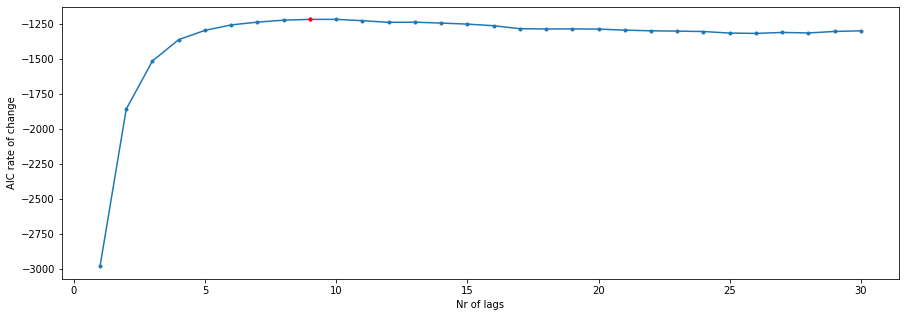

In [28]:
plt.figure(figsize=(15,5))
plt.plot(metrics['AIC'].diff(), marker='.')  # plot the difference to see where it flattens out
plt.plot(9, metrics['AIC'].diff()[9], '.r')
plt.xlabel("Nr of lags")
plt.ylabel("AIC rate of change")
plt.show()
plt.close()

The point shifted a little, improvement stagnates at 9 lags instead of 14.

In [29]:
# train and evaluate model with 0 to n lags
lags = 9

# prep data
X_train_interim = train.drop(drop_labels, axis=1)
X_train_interim[remaining_sensors] = scaler.transform(X_train_interim[remaining_sensors])
X_train_interim = make_stationary(X_train_interim, remaining_sensors)
X_train_interim = add_lagged_variables(X_train_interim, lags, remaining_sensors)
X_train_interim = sm.add_constant(X_train_interim)
X_train = X_train_interim.drop(index_names, axis=1)
y_train = X_train.pop("RUL")

X_test_interim = test.drop(drop_labels, axis=1)
X_test_interim[remaining_sensors] = scaler.transform(X_test_interim[remaining_sensors])
X_test_interim = make_stationary(X_test_interim, remaining_sensors)
X_test_interim = add_lagged_variables(X_test_interim, lags, remaining_sensors)
X_test_interim = X_test_interim.groupby('unit_nr').last().reset_index()
X_test_interim = sm.add_constant(X_test_interim)
X_test = X_test_interim.drop(index_names, axis=1)

# fit model
model = sm.OLS(y_train.clip(upper=125), X_train)  # apply clipped RUL from last post
model_fitted = model.fit()

# predict
y_hat_train = model_fitted.predict(X_train)
y_hat = model_fitted.predict(X_test)

# evaluate
evaluate(y_train.clip(upper=125), y_hat_train, 'train')
evaluate(y_test, y_hat)

C:\miniconda3\envs\nasa_turbofan\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\miniconda3\envs\nasa_turbofan\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


train set RMSE:20.80233928213837, Variance:0.7523208224684113
test set RMSE:21.14895857012398, Variance:0.7409888687595052


In [30]:
# train and evaluate model with specific lags
specific_lags = [1,2,3,4,5,10,20]

# prep data
X_train_interim = train.drop(drop_labels, axis=1)
X_train_interim[remaining_sensors] = scaler.transform(X_train_interim[remaining_sensors])
X_train_interim = make_stationary(X_train_interim, remaining_sensors)
X_train_interim = add_specific_lags(X_train_interim, specific_lags, remaining_sensors)
X_train_interim = sm.add_constant(X_train_interim)
X_train = X_train_interim.drop(index_names, axis=1)
y_train = X_train.pop("RUL")

X_test_interim = test.drop(drop_labels, axis=1)
X_test_interim[remaining_sensors] = scaler.transform(X_test_interim[remaining_sensors])
X_test_interim = make_stationary(X_test_interim, remaining_sensors)
X_test_interim = add_specific_lags(X_test_interim, specific_lags, remaining_sensors)
X_test_interim = X_test_interim.groupby('unit_nr').last().reset_index()
X_test_interim = sm.add_constant(X_test_interim)
X_test = X_test_interim.drop(index_names, axis=1)

# fit model
model = sm.OLS(y_train.clip(upper=125), X_train)
model_fitted = model.fit()

# predict
y_hat_train = model_fitted.predict(X_train)
y_hat = model_fitted.predict(X_test)

# evaluate
evaluate(y_train.clip(upper=125), y_hat_train, 'train')
evaluate(y_test, y_hat)

C:\miniconda3\envs\nasa_turbofan\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\miniconda3\envs\nasa_turbofan\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


train set RMSE:20.742950740267165, Variance:0.7542608298904978
test set RMSE:20.852234864407464, Variance:0.7482058292992069


## Results
specific lags and test rmse  
rmse = 21.7642, lags = [1,2,3,4,5]  
rmse = 21.1489, lags = [1,2,3,4,5,6,7,8,9]  
rmse = 21.0690, lags = [1,2,3,4,5,10,20,30]  
rmse = 20.8522, lags = [1,2,3,4,5,10,20]  

There are of course many more possibilities, but with minimal testing and taking into account the stagnating improvement from adding more continuous lags, lags [1,2,3,4,5,10,20] performed best with an rmse of 20.8522.  
These results come pretty close to our SVR from last time (RMSE = 20.54). The distributed lag model is a valuable addition to the possible solutions, giving great flexibility and control during model development while also being easy to explain and interpret by the business. 

In [31]:
## sources used:

# [1] https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3

# choosing the correct nr of lags
# https://stats.stackexchange.com/questions/226468/how-many-lags-should-i-include-in-time-series-prediction
# https://www.researchgate.net/post/How_do_you_choose_the_optimal_laglength_in_a_time_series

# distributed lag models
# https://stats.stackexchange.com/questions/189317/does-using-lagged-independent-variables-makes-sense
# https://www.reed.edu/economics/parker/312/tschapters/S13_Ch_3.pdf

# VAR
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

# unit root (stationarity)
# https://www.quora.com/What-is-unit-root-in-a-time-series
# https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
# https://www.quora.com/What-is-the-purpose-of-differencing-in-time-series-models

# multicolinearity and vif
# https://www.statisticshowto.datasciencecentral.com/variance-inflation-factor/
# https://stats.stackexchange.com/questions/332428/regression-model-constant-causes-multicollinearity-warning-but-not-in-standardi


# other posts
# http://people.duke.edu/~rnau/411l696.htm
# http://people.duke.edu/~rnau/timereg.html
# https://www.ethanrosenthal.com/2018/03/22/time-series-for-scikit-learn-people-part2/
# https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3
# https://towardsdatascience.com/almost-everything-you-need-to-know-about-time-series-860241bdc578
# https://www.machinelearningplus.com/time-series/time-series-analysis-python/
# https://stats.stackexchange.com/questions/94723/using-non-stationary-time-series-data-in-ols-regression